<div class="alert alert-block alert-info">
<b>Цель:</b> 
    
   
Определение комерчески успешных игр для прогнозирования рекламы на 2017 год.
Ниже приведен датафрейм с колличеством продаж игр, их названием, пользовательским рейтингом, оценкой критиков, возрастной группой, и распределение продаж по регионам. 
В работе будет проводиться анализ данного датафрейма с целью выявления лидеров рынка среди платформ и жанров. Будут определены  зависимости между колличеством продаж и пользовательским рейтингом/оценкой критиков для наиболее популярной платформы.  
</div>


<b> Импорты</b>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
from IPython.core.display import display, HTML  #для удобной работы




<b>Блок настройки Jypyterhub</b>

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>div.output_area pre {white-space: pre;}</style>"))

display(HTML("<style>.container { width:90% !important; }</style>"))

pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

### Подготовка данных

Загружаем таблицу и смотрим на первые пять строк.


In [3]:
data = pd.read_csv('/datasets/games.csv')

display(data.head())

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Случайная выборка из середины, для оценки однородности данных.

In [4]:
display(data.sample(10)) 

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
6637,Ben 10 Triple Pack,DS,2011.0,Misc,0.12,0.11,0.00,0.02,NaN,tbd,E10+
105,Fallout 4,PS4,2015.0,Role-Playing,2.53,3.27,0.24,1.13,87.0,6.5,M
7065,Mortal Kombat: Armageddon,Wii,2007.0,Fighting,0.19,0.02,0.00,0.02,71.0,8.4,M
15401,Atari Flashback Classics: Volume 2,XOne,2016.0,Misc,0.02,0.00,0.00,0.00,NaN,tbd,E
2017,Junior Brain Trainer,DS,2008.0,Misc,0.23,0.71,0.00,0.09,NaN,tbd,E
4607,James Bond 007: Everything or Nothing,GC,2004.0,Shooter,0.32,0.08,0.00,0.01,84.0,8.2,T
16158,Raven's Cry,PS4,2015.0,Role-Playing,0.00,0.01,0.00,0.00,NaN,NaN,NaN
5316,MotoGP 08,X360,2008.0,Racing,0.11,0.20,0.00,0.04,68.0,5.6,E
12084,Fantastic Four,PS,1997.0,Action,0.04,0.03,0.00,0.00,NaN,NaN,NaN
11519,The Sims 2: Ikea Home Stuff,PC,2008.0,Simulation,0.00,0.07,0.00,0.01,NaN,tbd,T


Описание  разброса числовых значений и общая информация о свойсттвах таблицы.

In [5]:
display(data.describe())
display (data.info())

,Year_of_Release,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score
count,16446.000000,16715.000000,16715.000000,16715.000000,16715.000000,8137.000000
mean,2006.484616,0.263377,0.145060,0.077617,0.047342,68.967679
std,5.877050,0.813604,0.503339,0.308853,0.186731,13.938165
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


None

 Обработка данных 

In [6]:
data.columns = data.columns.str.lower() 
data = data.drop_duplicates()

# преобразование типов
data['year_of_release'] = data['year_of_release'].fillna(0).astype(int)

# перевод в нижний регистр
data['name'] = data['name'].str.lower() 
data['genre'] = data['genre'].str.lower()
print('')

# смотрю кол-во пропусков
data[['na_sales', 'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating']].isna().sum()

# предполагаю, что игры без рейтинга - старые
data['year_of_release'].describe()
data_nan = data.query('critic_score == "NaN"')
data_nan['year_of_release'].describe()

# столбец с общими продажами
data['all_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']

#Есть нули в дате выпуска игры
# print(data[data['year_of_release'] == 0].count()) 
data = data.query('year_of_release != 0')


# Блок с тбд
data = data.replace('tbd', 'NaN')
data['user_score'] = data['user_score'].astype(float)
# print(actual_top_platforms['user_score'].isna().sum()) #посмотрел сколько всего таких
# print(actual_top_platforms.query('user_score == "NaN"').head(50)) #предполагаю что это игры с малыми продажами
data[data['user_score'] == 'NaN'] = data['user_score'].median()




# print(data.info())


/opt/conda/lib/python3.7/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


### Исследователький анализ данных. 

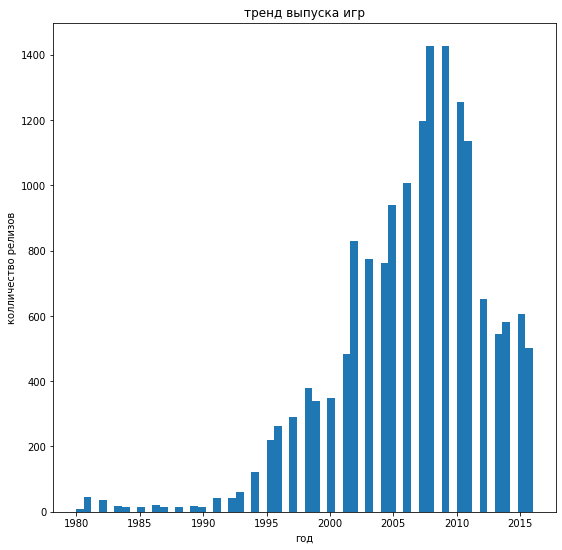

In [7]:
hist_trend = data['year_of_release'].plot(kind='hist', bins = 60, title='тренд выпуска игр', figsize=(9,9))
hist_trend.set_ylabel("колличество релизов")#Судя по диаграмме, я бы оставил данные только с 2003 года
hist_trend.set_xlabel("год")

data_platform = data.pivot_table(index='platform', values=['na_sales', 'eu_sales', 'jp_sales', 'other_sales'], aggfunc='sum')
data_platform['all_sales'] = (data_platform['eu_sales'] + data_platform['jp_sales'] + data_platform['na_sales'] + data_platform['other_sales'])
data_platform = data_platform.sort_values(by='all_sales', ascending=False)



# data_platform.plot(x=data_platform.index, y='all_sales', kind='scatter')

Text(0.5, 0, 'платформа')

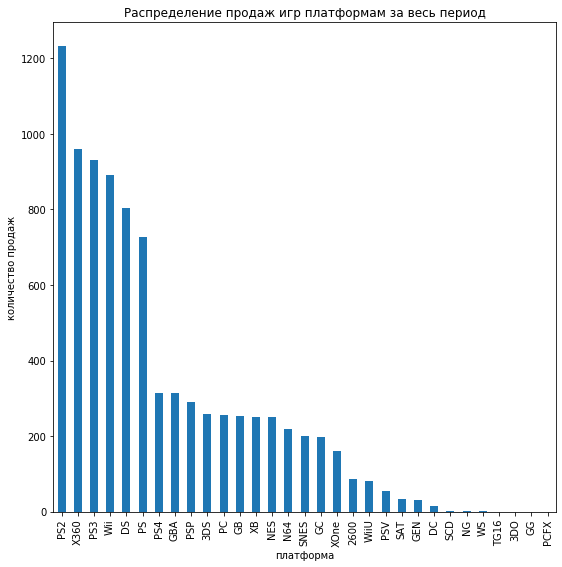

In [8]:
platform_hist = data_platform['all_sales'].plot(kind = 'bar', figsize=(9,9), title='Распределение продаж игр платформам за весь период')
platform_hist.set_ylabel("количество продаж")
platform_hist.set_xlabel("платформа")

# ds = data.query('platform ==  "DS"').plot(kind='scatter', x='year_of_release', y='all_sales', xlim=2003, title='DS')  #увидел выброс, поэтому обозначил лимит по годам
# ps2= data.query('platform ==  "PS2"').plot(kind='scatter', x='year_of_release', y='all_sales', title='PS2') #Судя по всему диси по-новее чем пс

Text(0.5, 0, 'год')

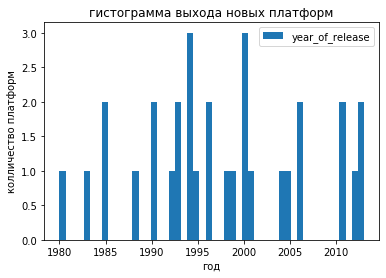

In [9]:
term_platform = data.pivot_table(index='platform', values='year_of_release', aggfunc='min').plot(kind='hist', bins=50, title='гистограмма выхода новых платформ')
term_platform.set_ylabel('колличество платформ')
term_platform.set_xlabel('год')

В данном блоке я создал актуальный список платформ, с датой первого релиза - 2013, таким образом я отсеял все старые платформы. На графике тренда выпуска игр виден скачок выпуска числа игр  в 2013 годы, этот год и принимаю в качестве начала актуального периода для дальнейшего анализа данных.

В среднем, новые платформы появляются каждые 2-3 года.


Text(0, 0.5, 'млн. шт.')

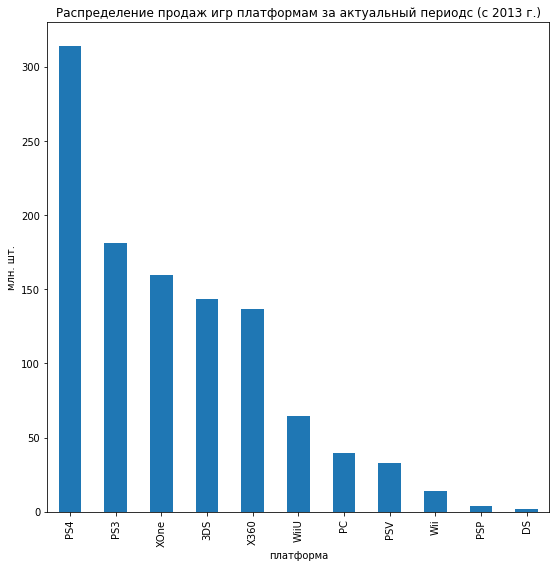

In [10]:
data_actual = data.query('year_of_release >= 2013').pivot_table(index='platform', values=['na_sales', 'eu_sales', 'jp_sales', 'other_sales'], aggfunc='sum') #По этой таблице и будем анализировать данные.

data_actual['all_sales'] = (data_actual['eu_sales'] + data_actual['jp_sales'] + data_actual['na_sales'] + data_actual['other_sales'])
data_actual = data_actual.sort_values(by='all_sales', ascending=False)
hist_actual = data_actual['all_sales'].plot(kind='bar', figsize=(9,9), title='Распределение продаж игр платформам за актуальный периодс (с 2013 г.)')
hist_actual.set_xlabel('платформа')
hist_actual.set_ylabel('млн. шт.')

#print(actual_top_games)



Наибольшее колличество игр вышло на ps4, а на ХOne почти также как и на PS3, 3DS и X360. С остальными кратный 2-х разрыв в продажах. 

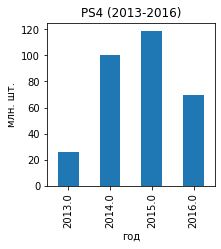

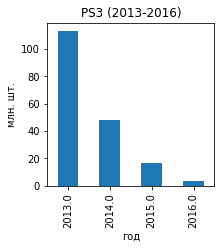

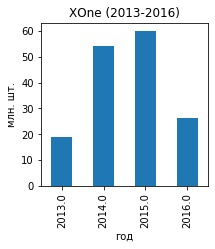

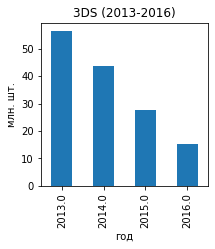

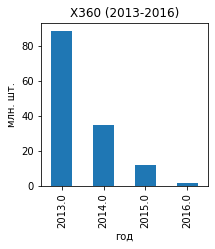

In [11]:
#готовим срез по актуальным платформам
top_platform = list(data_actual.head().index)
actual_top_platforms = data.query('year_of_release >= 2013 and platform in @top_platform')

# Посмотрим на тренд для 5 первых платформ
actual_top_platforms_hist = actual_top_platforms.pivot_table(index='year_of_release', values='all_sales', columns='platform', aggfunc='sum')

#функция для рисования графиков
def graf_bar(list_of_top): 
    for i in list_of_top:     
        hist = actual_top_platforms_hist[i].plot(kind='bar', figsize=(3,3), title=i+' (2013-2016)')
        hist.set_xlabel('год')
        hist.set_ylabel('млн. шт.')
        plt.show()
        
graf_bar(top_platform)
# print(top_platform)






/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, 'млн. шт.')

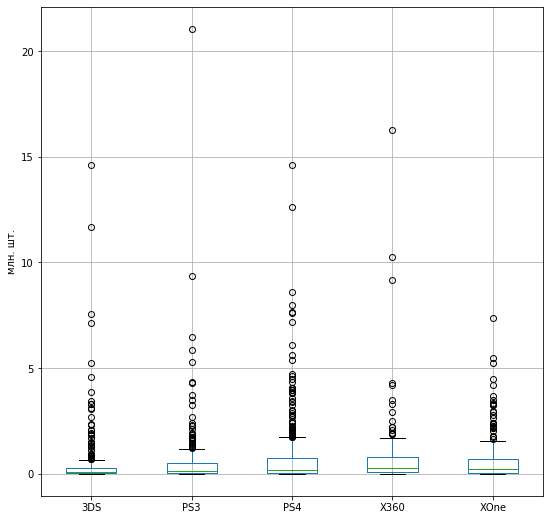

In [12]:
#  «ящик с усами» по глобальным продажам игр в разбивке по платформам
actual_top_platforms.pivot_table(index='name', values='all_sales', columns='platform',aggfunc='sum').boxplot(figsize=(9,9)).set_ylabel('млн. шт.')

Основная масса игр не очень хорошо продаются,  но есть бестселлеры, продажи которых в десятки раз больше чем продажи у всех остальных 

Text(0.5, 0, 'пользовательский рейтинг')

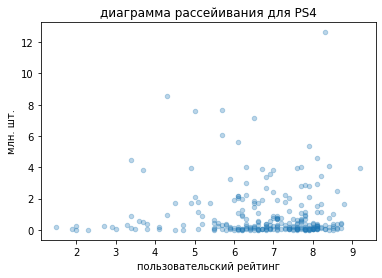

In [13]:
# Влияние отзывов пользователей и критиков  на продажи 

rating_sales = actual_top_platforms.query('platform == "PS4"') #Самые большие продажи на PS4



user_hist = rating_sales.plot(kind='scatter', y='all_sales', x='user_score', alpha=0.3, title='диаграмма рассейивания для PS4')
user_hist.set_ylabel('млн. шт.')
user_hist.set_xlabel('пользовательский рейтинг')

Text(0.5, 0, 'пользовательский рейтинг')

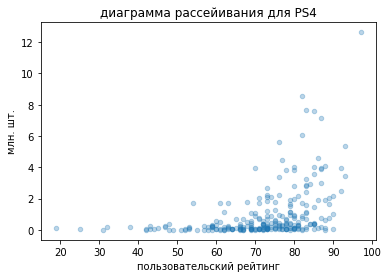

In [14]:
critic_hist = rating_sales.plot(kind='scatter', y='all_sales', x='critic_score', alpha=0.3, title='диаграмма рассейивания для PS4')
critic_hist.set_ylabel('млн. шт.')
critic_hist.set_xlabel('пользовательский рейтинг')

In [15]:
rating_sales = rating_sales[['critic_score', 'user_score', 'all_sales']] #Для нахождения коэф корреляции нужны эти три параметра
rating_sales.corr()

,critic_score,user_score,all_sales
critic_score,1.000000,0.557654,0.406568
user_score,0.557654,1.000000,-0.031957
all_sales,0.406568,-0.031957,1.000000


Для платформы PS4 есть зависимость колличества продаж от оценки критиков, коэффициент корреляции этих параметров 0.557.


Text(0.5, 0, 'пользовательский рейтинг')

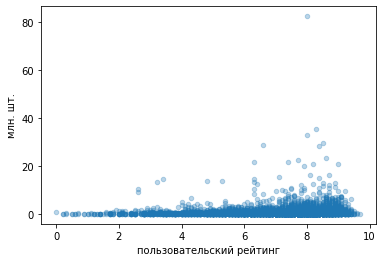

In [16]:
# Влияние отзывов пользователей и критиков  на продажи по остальным платформам вместе взятых
non_rating_sales = data.query('platform != "PS4"') 

user_all_score = non_rating_sales.plot(kind='scatter', y='all_sales', x='user_score', alpha=0.3)
user_all_score.set_ylabel('млн. шт.')
user_all_score.set_xlabel('пользовательский рейтинг')


Text(0.5, 0, 'пользовательский рейтинг')

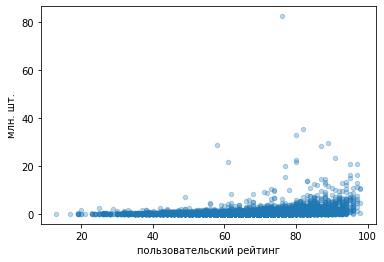

In [17]:
critic_all_score = non_rating_sales.plot(kind='scatter', y='all_sales', x='critic_score', alpha=0.3)
critic_all_score.set_ylabel('млн. шт.')
critic_all_score.set_xlabel('пользовательский рейтинг')

In [18]:
non_rating_sales = non_rating_sales[['critic_score', 'user_score', 'all_sales']] #Для нахождения коэф корреляции нужны эти три параметра

rating_sales.corr()


,critic_score,user_score,all_sales
critic_score,1.000000,0.557654,0.406568
user_score,0.557654,1.000000,-0.031957
all_sales,0.406568,-0.031957,1.000000


Определенная корреляция присутствует, но говорить о сильной взоимосвязи оценки критиков, пользователей и колличестве продаж не приходится. 
Ситуации c PS4 похожи, PS4 не выбивается из общей логики.

Text(0, 0.5, 'млн. шт.')

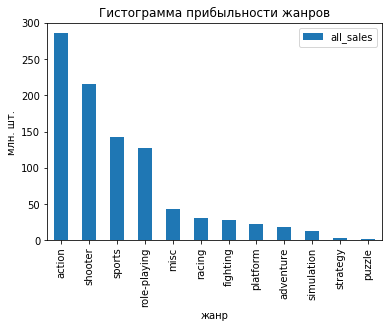

In [19]:
# Гистограмма прибыльности жанров
data_genre = actual_top_platforms.pivot_table(index='genre', values='all_sales', aggfunc='sum')
data_genre_hist = data_genre.sort_values(by='all_sales', ascending=False).plot(kind='bar', title ='Гистограмма прибыльности жанров')
data_genre_hist.set_xlabel('жанр')
data_genre_hist.set_ylabel('млн. шт.')


# print(data.head())

In [20]:
display(data_genre.sort_values(by='all_sales', ascending=False))

,all_sales
genre,
action,285.96
shooter,216.22
sports,142.48
role-playing,127.83
misc,43.57
racing,31.46
fighting,27.91
platform,22.88
adventure,18.59


Самые большие продажи в жанре экшн, далее шутер, примерно одинаково у спортивных и ролевых игр, а пара самых неприбыльных - пазлы и стратегии

In [21]:
# Портрет игрока в каждом регионе
def portrait (region_sales):
    region_portrait = actual_top_platforms[['name', 'platform', 'year_of_release', 'genre', region_sales, 'rating']]

    region_platform = region_portrait.pivot_table(index='platform',  values=region_sales, aggfunc='sum').sort_values(by=region_sales, ascending=False)
    region_platform['part_sales'] = region_platform[region_sales] / region_platform[region_sales].sum()
    region_platform['platform'] = region_platform.index 
    
    region_platform_hist = region_platform.plot(kind='bar', x='platform', y='part_sales', title='распределение продаж по платформам')
    region_platform_hist.set_xlabel('платформа')
    region_platform_hist.set_ylabel('доля продаж')
    
    region_genre = region_portrait.pivot_table(index='genre',  values=region_sales, aggfunc='sum').sort_values(by=region_sales, ascending=False)
    region_genre_hist =  region_genre.plot(kind='bar')
    region_genre_hist.set_xlabel('жанр')
    region_genre_hist.set_ylabel('млн. шт.')
   
    rating_pivot = region_portrait.pivot_table(index='rating', values=region_sales, aggfunc='sum').sort_values(by=region_sales, ascending=False)
    rating_pivot_hist = rating_pivot.plot(kind='bar')
    rating_pivot_hist.set_xlabel('возрастной рейтинг')
    rating_pivot_hist.set_ylabel('млн. шт.')
    
    display(region_platform.head())
    display(region_genre.head())
    display(rating_pivot.head())
    
    plt.show()

  

,na_sales,part_sales,platform
platform,,,
PS4,108.74,0.282280,PS4
XOne,93.12,0.241732,XOne
X360,81.66,0.211983,X360
PS3,63.50,0.164841,PS3
3DS,38.20,0.099164,3DS


,na_sales
genre,
action,113.72
shooter,103.89
sports,63.64
role-playing,42.39
misc,20.46


,na_sales
rating,
M,156.75
E,65.57
T,43.06
E10+,38.34


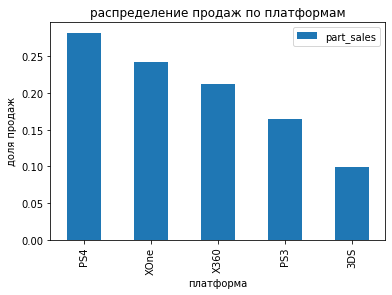

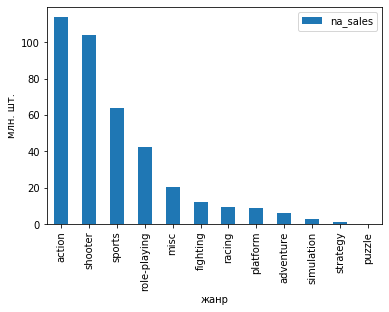

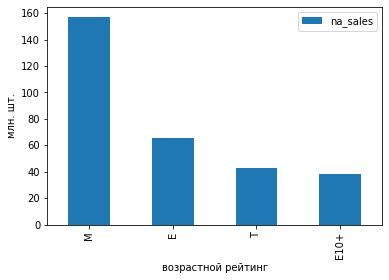

In [22]:
portrait('na_sales')

,eu_sales,part_sales,platform
platform,,,
PS4,141.09,0.422463,PS4
PS3,67.81,0.203042,PS3
XOne,51.59,0.154475,XOne
X360,42.52,0.127317,X360
3DS,30.96,0.092703,3DS


,eu_sales
genre,
action,105.06
shooter,79.99
sports,56.38
role-playing,32.70
racing,17.04


,eu_sales
rating,
M,133.07
E,69.06
T,33.63
E10+,28.37


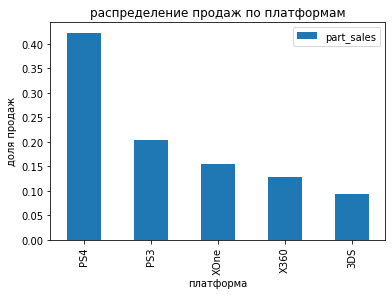

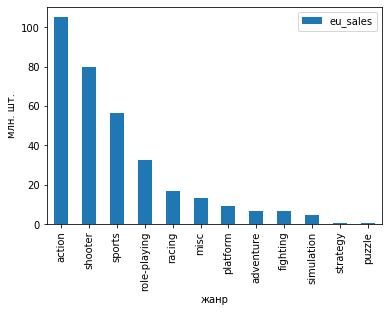

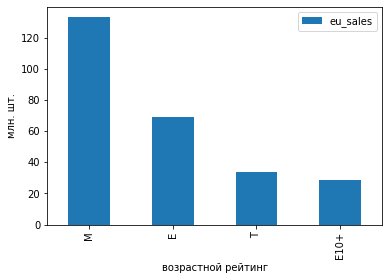

In [23]:
portrait('eu_sales')

,jp_sales,part_sales,platform
platform,,,
3DS,67.81,0.628045,3DS
PS3,23.35,0.216264,PS3
PS4,15.96,0.147819,PS4
X360,0.51,0.004724,X360
XOne,0.34,0.003149,XOne


,jp_sales
genre,
role-playing,42.50
action,32.82
fighting,5.98
shooter,5.02
misc,4.95


,jp_sales
rating,
T,14.91
M,12.45
E,9.56
E10+,3.32


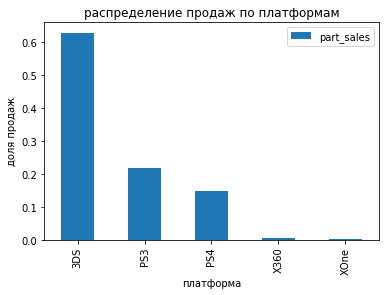

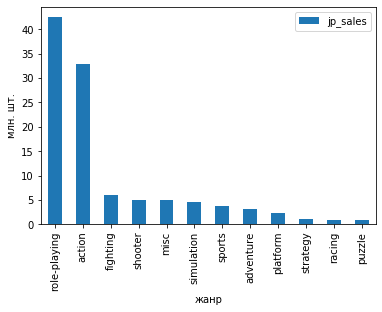

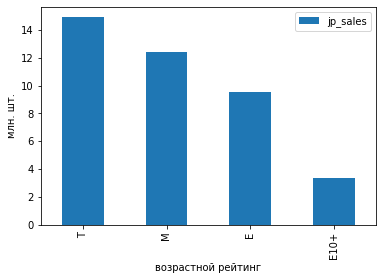

In [24]:
portrait('jp_sales')

<b> Промежуточный вывод: </b>

Лидер по платформам Северной Америки и Европы один и тот же, различие на 2 и 3 месте. В Америке XOne и X360, а в Европе PS3 и ХOne.

В Японии лидер 3DS, далее PS3 и PS4.
    
Распределение по жанрав в СА и Европе похожи: больше всего играют в экшн, далее шутер и спортивные игры, а Япония стоит особняком, там лидер - ролевые игры, далее файтинг и шутер, при этом есть многократный разрыв между первым и вторым место.    



###  Проверка гипотез

Нулевая теория: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Альтернативная теория: Средние пользовательские рейтинги платформ Xbox One и PC не одинаковые

In [25]:
# Готовлю 2 таблицы для прогонки ттестаВы
# Изучаю дисперсию, чтобы задать параметр равенства дисперсий
xb_user_score = data.query('platform == "XB"')
pc_user_score = data.query('platform == "PC"')

xb_user_score = xb_user_score.dropna(subset=['user_score'])
xb_var = np.var(xb_user_score['user_score'])


pc_user_score = pc_user_score.dropna(subset=['user_score'])
pc_var = np.var(pc_user_score['user_score'])

alpha = 0.05
results = st.ttest_ind(xb_user_score['user_score'], pc_user_score['user_score'], equal_var=False)

if results.pvalue > alpha:
    print ('Не получилось отвергнуть нулевую теорию' )
else:
    print('Нулевая теория отвергнута')
print(results.pvalue)

Нулевая теория отвергнута
3.69017314357026e-08


Нулевая теория: cредние пользовательские рейтинги жанров action  и sports равны.
    
Альтернативная теория: cредние пользовательские рейтинги жанров action  и sports различны. 

In [26]:
# Готовлю 2 таблицы для прогонки ттеста
# Изучаю дисперсию, чтобы задать параметр равенства дисперсий
action_user_score = data.query('genre == "action"')
sports_user_score = data.query('genre == "sports"')

action_user_score = action_user_score.dropna(subset=['user_score'])
action_var = np.var(action_user_score['user_score'])

sports_user_score = sports_user_score.dropna(subset=['user_score'])
sports_var = np.var(sports_user_score['user_score'])

# print(action_var)
# print(sports_var)

alpha = 0.05
results = st.ttest_ind(action_user_score['user_score'], sports_user_score['user_score'], equal_var=False)

if results.pvalue > alpha:
    print ('Не получилось отвергнуть нулевую теорию' )
else:
    print('Нулевая теория отвергнута')
print(results.pvalue)


# print(data.pivot_table(index='platform', values='all_sales', aggfunc='sum')) #тут смотрел сколько продаж по пс4 всего

Не получилось отвергнуть нулевую теорию
0.07370217419278534


<b>Вывод:</b> 

Платформы на которых играют  различаются от региона к региону, при этом жанры в большинстве своем схожи. 
    
В Северной Америке в лидерах платформ PS4 (108 млн. шт.),  меньше XOne (93. млн. шт.), еще меньше у X360 (81 млн. шт.), в Европе - PS4(141 млн. шт) и почти в два раза меньше продаж у PS3 (67 млн. шт), еще меньше у XOne(51 млн. шт.). 
В Японии больше всего играют на 3DS(67 млн. шт.), и на 34% меньше  на PS3(23 млн. шт.), еще меньше на PS4 (16 млн. шт.). По статистикке всех регионов, лидирует платформа PS4, более 320 млн. шт. копий игр вышло на неё с 2013 года.
    

Распределение по жанрам  в Европе и Америке одинакого. В Японии в лидерах ролевые игры(42 млн. шт.) и экшн(32 млн. шт.), далее идут файтинг(6 млн. шт.) и шутеры(5 млн. шт.).
    

По возрастным группам первая позиция везде "М", дальше  у "СА" и Европы одинаковая картина - двукратный разрыв с "Е". В Японии возрастная  "Т" имеет минимальный разрыв с лидером, и чуть больший разрыв с категорией "Е".  
    
В численном выражении, по всему миру больше всего играют в экшен (285 млн. шт.) и шутеры (216 млн. шт), а самая популярная платформа - PS4, за 2015 год было продано около 120 млн. шт. игр на эту платформу, а в 2016 порядка 72 млн. шт.
В целом рынок игр имеет отрицательную динамику, но гораздо лучше других выглядит  PS4, хоть и имеет сильный спад за 2016 год. 

